In [1]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set ONE consistent seaborn theme for all plots
sns.set_theme(style="whitegrid", palette="PuRd_r")

In [2]:
import os
import glob
import pandas as pd

# Load daily merged dataset (rides + weather)
daily_df = pd.read_csv("citibike_2022_daily_with_weather.csv")
daily_df["date"] = pd.to_datetime(daily_df["date"])
daily_df = daily_df.sort_values("date")

# Load trip-level dataset (from your folder data/2022-citibike-tripdata/*.csv)
trip_files = glob.glob(os.path.join("data", "2022-citibike-tripdata", "*.csv"))

trips_df = pd.concat(
    (pd.read_csv(f, low_memory=False) for f in trip_files),
    ignore_index=True
)

daily_df.head(), trips_df.shape

(        date  daily_ride_count  PRCP  TAVG  TMAX  TMIN
 0 2022-01-01             20428  19.3  11.6  13.9  10.0
 1 2022-01-02             43009   1.0  11.4  15.6   3.9
 2 2022-01-03             33189   0.0   1.4   3.9  -4.3
 3 2022-01-04             36842   0.0  -2.7   2.2  -6.0
 4 2022-01-05             34230   6.1   3.2   8.9   0.0,
 (29695532, 13))

/var/folders/99/3kg72zp954gd3p3xv3wv42s80000gn/T/ipykernel_2910/58933969.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


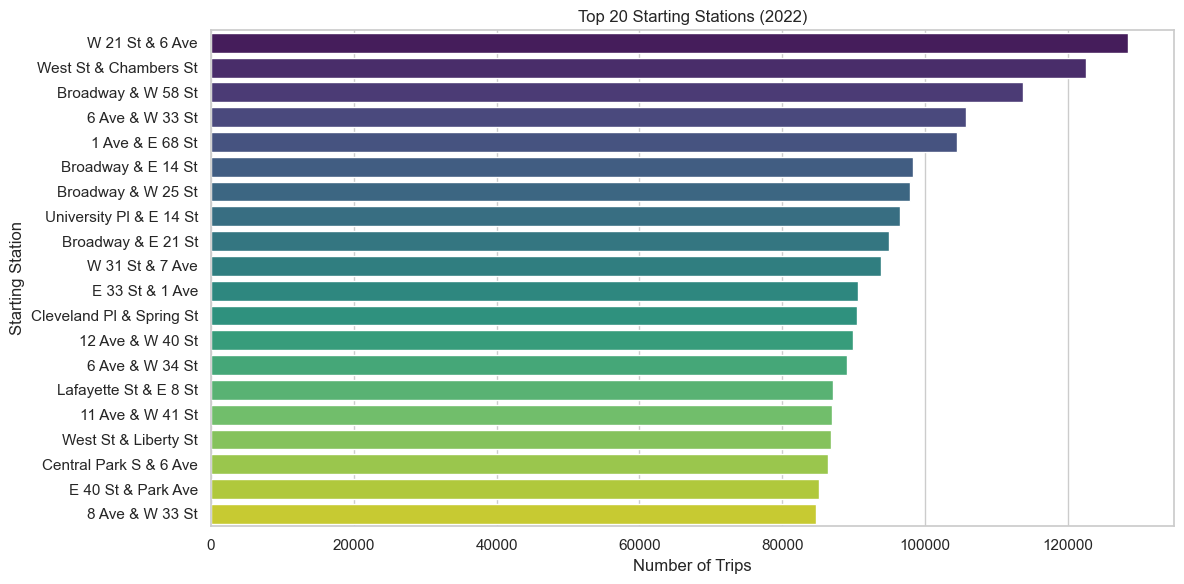

In [3]:
# Top 20 starting stations (bar chart)

top20 = (
    trips_df["start_station_name"]
    .value_counts()
    .head(20)
    .reset_index()
)
top20.columns = ["start_station_name", "count"]

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top20,
    y="start_station_name",
    x="count",
    palette=sns.color_palette("viridis", 20)  # 20 distinct shades
)

plt.title("Top 20 Starting Stations (2022)")
plt.xlabel("Number of Trips")
plt.ylabel("Starting Station")
plt.tight_layout()
plt.show()

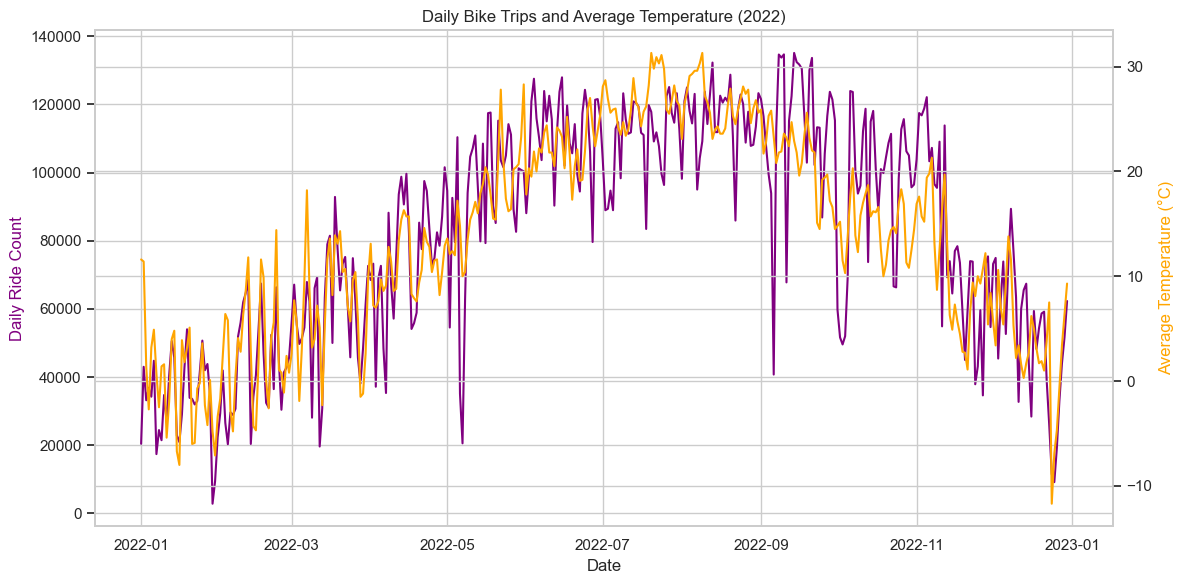

In [4]:
# Dual-axis line plot (Seaborn version)

fig, ax1 = plt.subplots(figsize=(12, 6))

# Trips line
sns.lineplot(
    data=daily_df,
    x="date",
    y="daily_ride_count",
    ax=ax1,
    color="purple"
)

ax1.set_ylabel("Daily Ride Count", color="purple")
ax1.set_xlabel("Date")

# Temperature line (second axis)
ax2 = ax1.twinx()

sns.lineplot(
    data=daily_df,
    x="date",
    y="TAVG",
    ax=ax2,
    color="orange"
)

ax2.set_ylabel("Average Temperature (°C)", color="orange")

plt.title("Daily Bike Trips and Average Temperature (2022)")
plt.tight_layout()
plt.show()

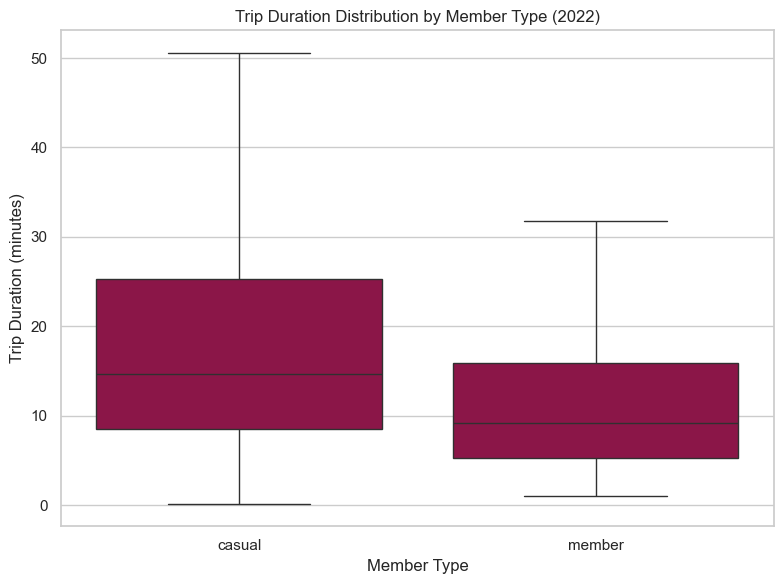

In [9]:
# Boxplot: Trip duration by member type (we compute tripduration from timestamps)

# Convert timestamps to datetime
trips_df["started_at"] = pd.to_datetime(trips_df["started_at"])
trips_df["ended_at"] = pd.to_datetime(trips_df["ended_at"])

# Create trip duration in minutes
trips_df["tripduration_min"] = (trips_df["ended_at"] - trips_df["started_at"]).dt.total_seconds() / 60

# Remove invalid durations (<= 0 or extremely long trips that break the plot)
trips_clean = trips_df[(trips_df["tripduration_min"] > 0) & (trips_df["tripduration_min"] < 300)].copy()

plt.figure(figsize=(8, 6))

sns.boxplot(
    data=trips_clean,
    x="member_casual",
    y="tripduration_min",
    showfliers=False
)

plt.title("Trip Duration Distribution by Member Type (2022)")
plt.xlabel("Member Type")
plt.ylabel("Trip Duration (minutes)")
plt.tight_layout()
plt.show()

## Box Plot Analysis: Trip Duration by Member Type

The box plot shows that casual riders have a higher median trip duration than members, indicating that casual users tend to take longer rides. The interquartile range (IQR) for casual riders is also wider, suggesting greater variability in trip duration compared to members. Members generally have shorter and more consistent trip times, likely reflecting commuting behavior. The whiskers indicate that casual riders also have longer maximum trip durations. Overall, the plot suggests behavioral differences between casual riders and subscribed members.

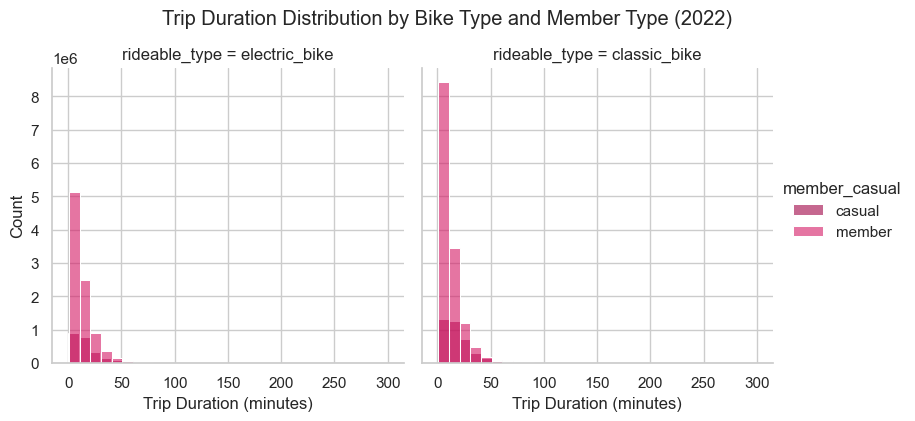

In [10]:
# FacetGrid: Trip duration by member type and rideable type

g = sns.FacetGrid(
    trips_clean,
    col="rideable_type",
    hue="member_casual",
    height=4,
    aspect=1
)

g.map(sns.histplot, "tripduration_min", bins=30, alpha=0.6)
g.add_legend()

g.set_axis_labels("Trip Duration (minutes)", "Count")
g.fig.suptitle("Trip Duration Distribution by Bike Type and Member Type (2022)", y=1.05)

plt.show()

## FacetGrid Analysis: Trip Duration by Bike Type and Member Type

The FacetGrid shows that trip duration distributions are right-skewed for both bike types, with most trips concentrated under 30 minutes. Members tend to have shorter and more consistent ride durations across both classic and electric bikes. Casual riders show greater variability and a higher frequency of longer rides, particularly on classic bikes. The separation by bike type helps reveal that overall usage patterns are similar across bike types, but behavioral differences between casual riders and members remain consistent.